# Predicting prices in Seattle.

## Goal:
* Use the categorical and numeric features to predict the prices in Seattle.

## Data:
* df - Preprocessed listings data from the the Data preprocessing notebook.

## Questions:
* What numeric features are correlated with the prices
* What categorical features have a relationship with the prices
* How well do the selected features predict the prices in Seattle.

## Methods:
* Build function to create the features.
* Buid a function to split, train and predict prices.
* Machine Learning model - Linear Regression.

## Model selection motivation
* I opted for a linear regression model because it is simple, easy to track and interprete the results.

# Import libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV

import numpy as np
%matplotlib inline

from ipynb.fs.full.my_functions import lm_mod

# Import preprocessed data to dataframes

In [2]:
df = pd.read_pickle('Seattle_data/clean_lisitings.pkl')

In [3]:
# Information of the columns in the dataframe.
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3816 entries, 0 to 3817
Data columns (total 87 columns):
id                                  3816 non-null int64
listing_url                         3816 non-null object
scrape_id                           3816 non-null int64
last_scraped                        3816 non-null object
name                                3816 non-null object
summary                             3639 non-null object
space                               3248 non-null object
description                         3816 non-null object
neighborhood_overview               2785 non-null object
notes                               2211 non-null object
transit                             2883 non-null object
thumbnail_url                       3496 non-null object
medium_url                          3496 non-null object
picture_url                         3816 non-null object
xl_picture_url                      3496 non-null object
host_id                             3816

In [4]:
# The descriptive statistics of the response variable
df['price'].describe()

count    3816.000000
mean      127.723198
std        89.139353
min        20.000000
25%        75.000000
50%       100.000000
75%       150.000000
max       999.000000
Name: price, dtype: float64

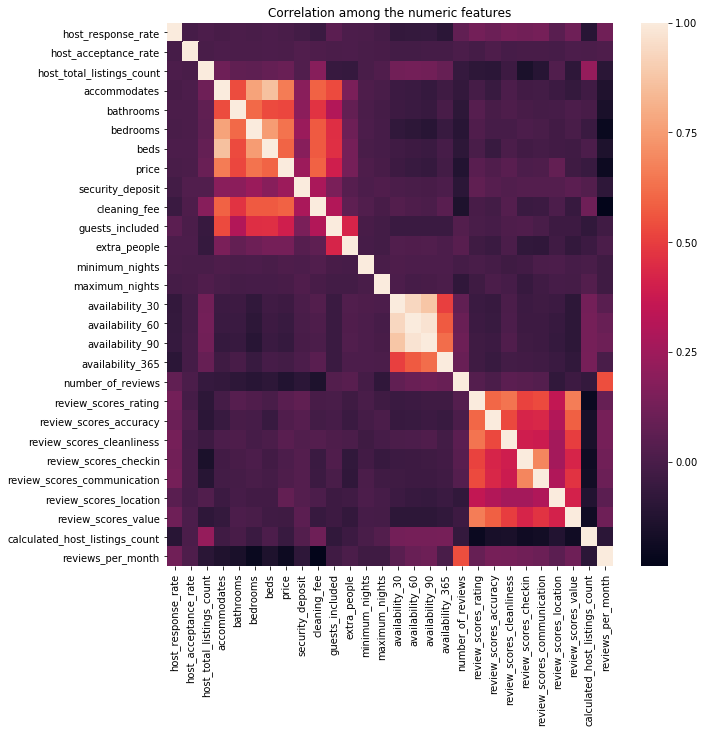

In [5]:
# Revisit the correlations from the Listings_EDA notebook.
plt.figure(figsize=(10,10))
dff = df.drop(['id','scrape_id','host_id','latitude','longitude','host_listings_count'],axis=1)
ax = sns.heatmap(dff.corr());
plt.title('Correlation among the numeric features');

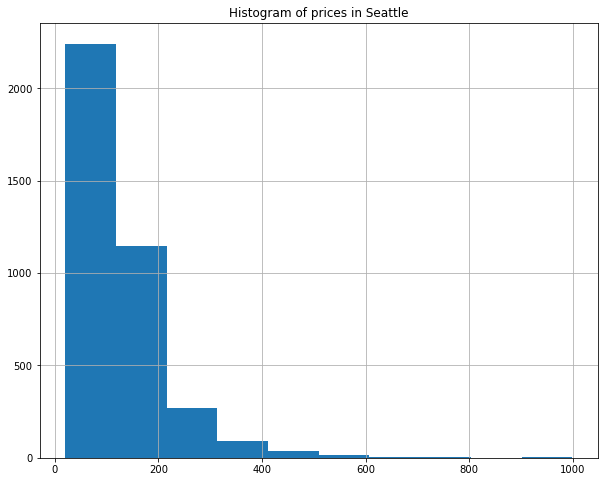

In [6]:
# Price Histogram - show the distribution of the prices
plt.figure(figsize=(10,8))
df['price'].hist();
plt.title('Histogram of prices in Seattle');

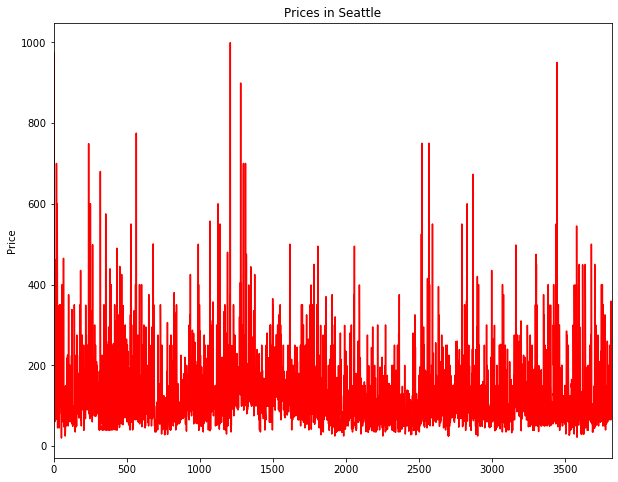

In [7]:
# Prices 
plt.figure(figsize=(10,8))
df['price'].plot(c='r')
plt.ylabel('Price')
plt.title('Prices in Seattle');

# Create features

In [8]:
def create_features(df):
    '''
    INPUT
    df - preprocessed listings dataframe
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the columns that are not relevant for the predicton.
    2. Drop any rows with missing values.
    3. Remove outliers below the 1% and above the 99% percentiles based on the Price column.
    4. Create y as the price column
    5. Create dummy columns for all the categorical variables, drop the original columns
    6. Create X as all the columns that are not the price column
    '''    
    # Drop all columns that are irrelavant for 
    df = df[['room_type','accommodates', 'beds','price','bathrooms','bedrooms','bed_type','host_is_superhost',
             'security_deposit','cleaning_fee','neighbourhood_group_cleansed','review_scores_cleanliness',
             'extra_people','cancellation_policy','instant_bookable','host_listings_count','review_scores_rating','review_scores_communication']]
    
    # Removing outliers 
    df = df[df['price'].between(df['price'].quantile(.01), df['price'].quantile(.99))] 

    # Drop any NaNs left in the dataframe
    df = df.dropna(how='any',axis=0)
    # Define the reponse variable
    
    y = df['price']
    
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
    # for each cat add dummy var, drop original column    
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
        
    # Define the response column
    X = df.drop(['price'],axis=1)
    
    return X, y 

In [9]:
X,y = create_features(df)

# Model

In [10]:
def lm_mod(X, y,test_size = .30, random_state=42, plot=True):
    
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    Plots - Predictions & Actual and Predictions & Differences
    Table - Features' importance arranged in descending orders of the absolute coefficients.
    '''
    
    # Split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42);
    
    # Fit the model and obtain pred response
    lm_model = LinearRegression(normalize=True) 
    lm_model.fit(X_train, y_train)
    y_test_preds = lm_model.predict(X_test)
    y_train_preds = lm_model.predict(X_train)
    
    # r2 and mse values from the train and test sets
    r2_scores_train=r2_score(y_train, y_train_preds)
    print ("r2_scores_train = {}".format(r2_scores_train))
    r2_scores_test=r2_score(y_test, y_test_preds)
    print ("r2_scores_test = {}".format(r2_scores_test))
    
    
    mse_score_train=mean_squared_error(y_train, y_train_preds)
    print ("mse_score_train = {}".format(mse_score_train))
    mse_score_test=mean_squared_error(y_test, y_test_preds)
    print ("mse_score_test = {}".format(mse_score_test))
    
    preds_vs_act = pd.DataFrame(np.hstack([y_test.values.reshape(y_test.size,1), y_test_preds.reshape(y_test.size,1)]));
    preds_vs_act.columns = ['actual', 'preds'];
    preds_vs_act['diff'] = preds_vs_act['actual'] - preds_vs_act['preds'];


    plt.plot(preds_vs_act['preds'], preds_vs_act['actual'], 'bo');
    plt.xlabel('predicted');
    plt.ylabel('Actual');
    plt.title('Predictions & Actual');
    plt.show()
    
    plt.plot(preds_vs_act['preds'], preds_vs_act['diff'], 'ro');
    plt.xlabel('predicted');
    plt.ylabel('diff');
    plt.title('Predictions & Difference');
    plt.show()
    
    coefs_df = pd.DataFrame()

    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    print(coefs_df.sort_values('abs_coefs', ascending=False))
       
    return lm_model

r2_scores_train = 0.6369687994442548
r2_scores_test = 0.6195679179546376
mse_score_train = 1831.4011040036085
mse_score_test = 2227.1047065312837


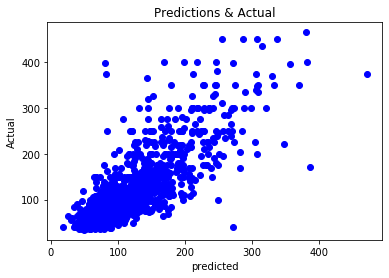

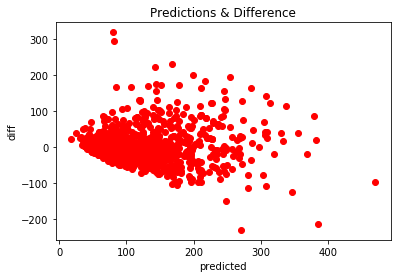

                                             est_int      coefs  abs_coefs
12                             room_type_Shared room -54.383663  54.383663
11                            room_type_Private room -31.286522  31.286522
23             neighbourhood_group_cleansed_Downtown  23.382829  23.382829
3                                           bedrooms  22.802943  22.802943
27            neighbourhood_group_cleansed_Northgate -22.717474  22.717474
29           neighbourhood_group_cleansed_Queen Anne  21.250170  21.250170
2                                          bathrooms  21.202863  21.202863
22             neighbourhood_group_cleansed_Delridge -20.685055  20.685055
19         neighbourhood_group_cleansed_Capitol Hill  18.676727  18.676727
20              neighbourhood_group_cleansed_Cascade  17.990255  17.990255
31          neighbourhood_group_cleansed_Seward Park -16.506565  16.506565
18          neighbourhood_group_cleansed_Beacon Hill -16.187171  16.187171
30       neighbourhood_gr

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [11]:
lm_mod(X,y)

## Findings:
### Model evaluation
* Based on the train and test r2 scores, performs well on both the test and train data sets which is a good sign!
  A good sign that the model does not overfit the data.
* The features selected can predict 62% of the variations in the prices in Seattle based on the test r2 score.
* Based on the Prediction VS Actual plot, the model is performs better when predicting prices between 0 and 300.
* Model fails to predict the extreme values, this is expected and probably adding more features can improve the performance.
### Features importance
* Group features room_type,neighbourhood and bedrooms are the top 3 most significant features.
* Room_type_shared_room is the most significant and is negatively correlated. 
  This means that choosing a shared room will lower the price by 54 dollars.
* Room_type_private_room guarantees a price lower by 31 dollars.
* Choosing a listing in Downtown neigbhourhood will increase the price by 23 dollars.
  This is expected because Downtown has the highest median price 139 dollars (see Listing_EDA notebook)
* Bedrooms and bathrooms have a positive relationship with the prices(increase the price by 23 and 21 respectively)
* Host_lisitings _count have a less than unit impact on the price of the price. 
  However it should be noted that there is a negative relationship, an host with more listings will offer a lower price.
I suspect Economies of scale benefit. 

### Challenges
* There are so many categorical features which makes it hard to select the right features.
 I believe engineering and adding more categorical features might improve the model performance.
